# Задача классификации рукописных цифр. Первая нейронная сеть с использованием фреймворка PyTorch.

In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Датасет MNIST содержит 70000 рукописных изображений цифр, 60000 - для обучения, 10000 - для тестирования.

Загрузим датасет MNIST и нормализуем его.
Нормализация происходит с помощью вычитания среднего (0.1307) и деления на стандартное отклонение (0.3081).

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [28]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

Один batch в тесте имеет размерность:

In [29]:
example_data.shape

torch.Size([1000, 1, 28, 28])

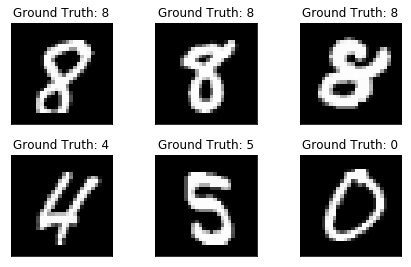

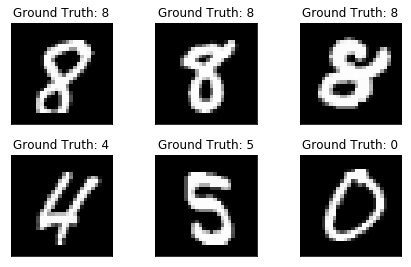

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [31]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Построим нашу нейронную сеть. Она будет состоять из двух 2D-свёрточных слоёв, а затем из двух полносвязных слоев (linear). Функция активации - rectified linear unit (ReLu). В качестве регуляризации используем два dropout слоя. 

Хороший способ создать нейронную сеть в PyTorch - написать класс. 

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [33]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

### Обучение модели

In [34]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [35]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(network.state_dict(), './results/model.pth')
        torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [36]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Запустим один раз функцию test до обучения, чтобы посмотреть на acuuracy/loss, которые мы получаем с рандомными параметрами сети.

In [37]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\elena\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3036, Accuracy: 1016/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.343688
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.296945
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.235057
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.279737
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.263274
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.252942
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.219494
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.124684
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.053190
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.952867
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.878618
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.899263
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.767998
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.629218
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.529902
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.416420
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.341501
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.337894
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.085644
Train Epoch: 1 [12160

Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.465517
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.561369
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.310667
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.452544
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.417103
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.432575
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.465226
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.291322
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.454973
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.236375
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.449621
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.350485
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.336980
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.373087
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.367361
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.164667
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.138506
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.398022
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.528530
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.309334


### Оценка качества модели

Text(0, 0.5, 'negative log likelihood loss')

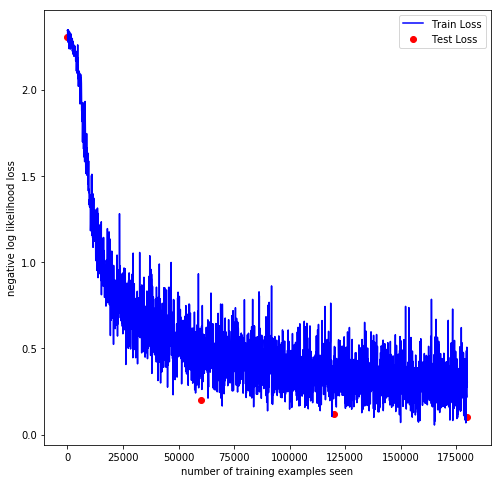

In [42]:
fig = plt.figure(figsize=(8,8))
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Посмотрим на несколько изображений и на предсказания модели.

In [44]:
with torch.no_grad():
    output = network(example_data)

C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


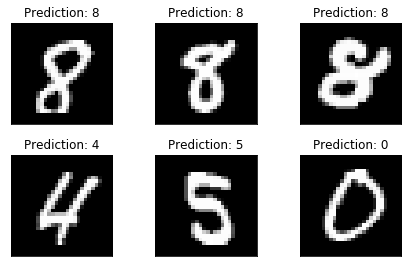

In [45]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
      output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

## Продолжим обучение нейронной сети с того момента, на котором мы его остановили.

In [46]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [47]:
network_state_dict = torch.load("./results/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("./results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [48]:
for i in range(4,9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.294024
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.241910
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.257000
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.252181
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.130325
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.371412
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.265403
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.198595
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.335186
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.296560
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.164704
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.252237
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.369781
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.123762
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.254912
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.404694
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.301243
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.290617
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.248697
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.398555
Train Epoch: 4 [12800/60000 (

Train Epoch: 5 [44160/60000 (74%)]	Loss: 0.190379
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.178156
Train Epoch: 5 [45440/60000 (76%)]	Loss: 0.125350
Train Epoch: 5 [46080/60000 (77%)]	Loss: 0.252223
Train Epoch: 5 [46720/60000 (78%)]	Loss: 0.254151
Train Epoch: 5 [47360/60000 (79%)]	Loss: 0.232304
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.261140
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.225273
Train Epoch: 5 [49280/60000 (82%)]	Loss: 0.442187
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.250738
Train Epoch: 5 [50560/60000 (84%)]	Loss: 0.253917
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.106850
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.169486
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.196872
Train Epoch: 5 [53120/60000 (88%)]	Loss: 0.181510
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.277794
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.228733
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.336554
Train Epoch: 5 [55680/60000 (93%)]	Loss: 0.303036
Train Epoch: 5 [56320/60000 (94%)]	Loss: 0.402368


Train Epoch: 7 [27520/60000 (46%)]	Loss: 0.218428
Train Epoch: 7 [28160/60000 (47%)]	Loss: 0.118385
Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.135882
Train Epoch: 7 [29440/60000 (49%)]	Loss: 0.225950
Train Epoch: 7 [30080/60000 (50%)]	Loss: 0.223915
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.385731
Train Epoch: 7 [31360/60000 (52%)]	Loss: 0.122088
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.529495
Train Epoch: 7 [32640/60000 (54%)]	Loss: 0.122044
Train Epoch: 7 [33280/60000 (55%)]	Loss: 0.164226
Train Epoch: 7 [33920/60000 (57%)]	Loss: 0.176576
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.253752
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.258316
Train Epoch: 7 [35840/60000 (60%)]	Loss: 0.104787
Train Epoch: 7 [36480/60000 (61%)]	Loss: 0.297085
Train Epoch: 7 [37120/60000 (62%)]	Loss: 0.179947
Train Epoch: 7 [37760/60000 (63%)]	Loss: 0.220884
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.171052
Train Epoch: 7 [39040/60000 (65%)]	Loss: 0.169437
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.391294


Визуализируем качество модели.

Text(0, 0.5, 'negative log likelihood loss')

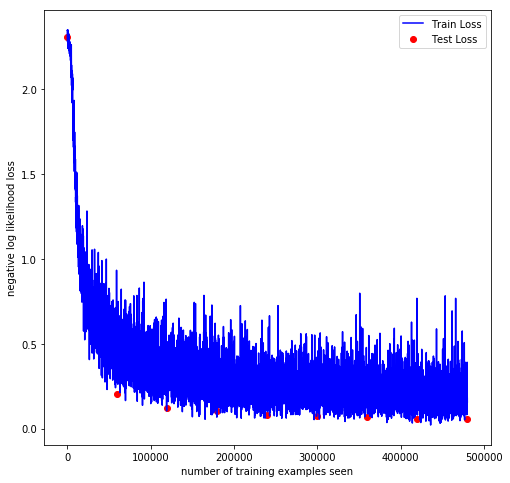

In [50]:
fig = plt.figure(figsize=(8,8))
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Мы видим, что мы повысили качество модели, не переобучившись.